# Packet Capture Anomaly Detection and Analysis

### In this notebook, we will combine several popular python libraries for PCAP analysis to provide a framework for online, unsupervised anomaly detection and network analysis

This notebook is broken up into two sections: the first section investigates an online, unsupervised approach to network intrusion detection systems (NIDS) using the python package `Kitsune` and `KitNET`. The second section explores data analysis options using python's `pcapkit` library to extract packet payloads. 

## Kitsune 
[Kitsune](https://github.com/ymirsky/Kitsune-py) is an online network intrusion system based on an ensemble of autoencoders. Artificial neural networks (ANNs) have been successful in improving detection performance, as they are good at learning complex non-linear concepts from the input data. However, traditionally ANNs have been used in a supervised approach: having an expert collect and label normal and anomalous network patterns, training the model offline, embedding it on a router and running batch sets of data through the model to detect intrusion. This is not the most efficient solution for several reasons, cheifly being that the time it takes to label data for a supervised learning approach is impractical (as the training set should be customized to the network it is being used for), and since offline processing does not scale to demands of millions of packets being processed per hour.

Thus, Kitsune was invented as a solution to offer online, unsupervised, low complexity processing. The details of how Kitsune and KitNET, Kitsun'e anomaly detection algorithm, can be found in [this paper](https://github.com/ymirsky/Kitsune-py/blob/master/Kitsune%20paper.pdf), but we will briefly address how the logic of it works here. 

### How Kitsune Works
<img src="kitsune_fig.png" alt="drawing" height='270' width="600"/>
<div align="center"><i>KitNET's Architectural Diagram <a href='https://github.com/ymirsky/Kitsune-py'>Source</a></i></div>
We chose Kitsune for this project as it provides the following traits that are needed for a NIDS framework:

- Highly scalable for processing full PCAP data and extracting features for an ANN
- unsupervised approach does not require subject matter expert labeling or maintanance
- can be offered online and operaetes on edge devices with limited compute and storage requirements

Kitsune operates by (1) monitoring the statistical patterns of recent network traffic, and (2) detecting anomalous patterns via an ensemble of autoencoders. The ensemble of autoencoders decodes a packet then re-encodes it based on weights it learned from the training portion of the process. It then compares the difference (as an RMSE score) between the original and re-contructed packet, where the higher the RMSE score, the more likely anomalous it is.  

<img src="kitsune_learned_rep.png" alt="drawing" height='270' width="500"/>
<div align="center"><i>During training, autoencoder computes the difference (RMSE) between the <br> original data and it’s learned representation <a href='https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd'>Source 1</a> / <a hred='https://medium.com/@anno.ai/scalable-machine-learning-for-packet-capture-data-with-kubeflow-b485a64c870a'>Source 2</a></i></div>


#### <i> Implimentation notes from the creator:
<i>This python implimentation of Kitsune is is not optimal in terms of speed. To make Kitsune run as fast as described in the paper, the entire project must be cythonized, or implimented in C++.</i>.
    
    
## Kitsune Walkthrough
We begin by importing the needed packages, unzipping out `PCAP` files, and instantiating a `Kitsune` and `FeatureExtractor` object with the size parameters outlined in the code. With these objects, we iterate through the packets and collect the RMSE scores for further analysis. 



In [1]:
from Kitsune import Kitsune
import numpy as np
import time
import pyshark
import FeatureExtractor
import zipfile
import pcapkit

# Load sample data: Mirai pcap (a recording of the Mirai botnet malware being activated)
# The first 70,000 observations are clean...
print("Unzipping Sample Capture...")
with zipfile.ZipFile("mirai.zip","r") as zip_ref:
    zip_ref.extractall()

# File location
path = "mirai.pcap" #the pcap, pcapng, or tsv file to process.
packet_limit = np.Inf #the number of packets to process

#extract PCAP packet for analysis
print('extracting')
extraction = pcapkit.extract(fin=path, nofile=True)

# KitNET params:
maxAE = 10 #maximum size for any autoencoder in the ensemble layer
FMgrace = 5000 #the number of instances taken to learn the feature mapping (the ensemble's architecture)
ADgrace = 50000 #the number of instances used to train the anomaly detector (ensemble itself)

# Build Kitsune
K = Kitsune(path,packet_limit,maxAE,FMgrace,ADgrace)
FE = FeatureExtractor.FE(path,packet_limit)

print("Running Kitsune:")
RMSEs = []
i = 0
start = time.time()
# Here we process (train/execute) each individual packet.
# In this way, each observation is discarded after performing process() method.
while True:
    i+=1
    if i % 10000 == 0:                                     #keep track of progress
        print(i)
    rmse = K.proc_next_packet()
    if rmse == -1:
        break
    RMSEs.append(rmse)
stop = time.time()
print("Complete. Time elapsed: "+ str(stop - start))


Importing Scapy Library
Unzipping Sample Capture...
extracting
tshark not found. Trying scapy...
Reading PCAP file via Scapy...
Loaded 764137 Packets.
Feature-Mapper: train-mode, Anomaly-Detector: off-mode
tshark not found. Trying scapy...
Reading PCAP file via Scapy...
Loaded 764137 Packets.
Running Kitsune:
The Feature-Mapper found a mapping: 100 features to 16 autoencoders.
Feature-Mapper: execute-mode, Anomaly-Detector: train-mode
10000
20000
30000
40000
50000
Feature-Mapper: execute-mode, Anomaly-Detector: execute-mode
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
73000

# Visualizing the Results
Here we demonstrate how one can fit the RMSE scores to a log-normal distribution (useful for finding/setting a cutoff threshold, $\phi$, and for visualizing potential anomolies)

Plotting results


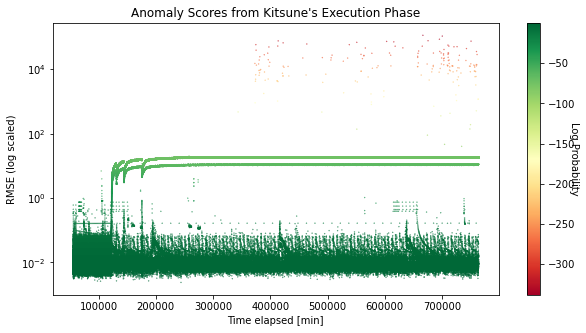

In [2]:
from scipy.stats import norm
benignSample = np.log(RMSEs[FMgrace+ADgrace+1:100000])
logProbs = norm.logsf(np.log(RMSEs), np.mean(benignSample), np.std(benignSample))

# plot the RMSE anomaly scores
print("Plotting results")
from matplotlib import pyplot as plt
from matplotlib import cm
plt.figure(figsize=(10,5))
fig = plt.scatter(range(FMgrace+ADgrace+1,len(RMSEs)),RMSEs[FMgrace+ADgrace+1:],s=0.1,c=logProbs[FMgrace+ADgrace+1:],cmap='RdYlGn')
plt.yscale("log")
plt.title("Anomaly Scores from Kitsune's Execution Phase")
plt.ylabel("RMSE (log scaled)")
plt.xlabel("Time elapsed [min]")
figbar=plt.colorbar()
figbar.ax.set_ylabel('Log Probability\n ', rotation=270)
plt.show()

In [3]:
import pandas as pd
rmse_series = pd.Series(RMSEs)
print('RMSE stats: \n ' , rmse_series.describe())
outlier_score = rmse_series.mean() + rmse_series.std()*2
#Potential outliers to ping as anomolies 
outlier_ix = list(rmse_series[rmse_series> outlier_score].index)
print('Total of ', len(outlier_ix), 'outliers detected')

RMSE stats: 
  count    764137.000000
mean         17.526689
std         438.753437
min           0.000000
25%           0.040849
50%          17.886273
75%          18.300283
max      112256.870896
dtype: float64
Total of  169 outliers detected


# Part 2: Using pcapkit.extract for Packet Analysis

While Kitsune does provide a feature extractor that handles packet features as vectors, once an anomalous packet is detected we might want to do some digging into some of its metadata for further intrusion prevention. PCAPKit is a great library for doing this analysis in python. Their `extraction` module offer metadata as shown in the cells below:

In [4]:
outlier_packets = [extraction.frame[x] for x in outlier_ix]
outlier_packets[0]

<Frame Info(frame_info=Info(...), time=datetime.datetime(2018, 10, 25, 3, 18, 56, 992942), number=373053, time_epoch=1540451936.992942, len=84, cap_len=84, packet=b'L\t\xd4\xc6\x12{\x00\x16l\x7f\x82 \x08\x00E\x00\x00F\x0c\xb1@\x00@\x11\xa81\xc0\xa8\x02s\xc0\xa8\x02\x01\t\x90\x005\x002K\xb9\x02\xeb\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x04xmpp\x0fsamsungsmartcam\x03com\x00\x00\x01\x00\x01', ethernet=Info(...), protocols='Ethernet:IPv4:UDP:Raw')>

In [80]:
#Creating a dictionary to story some metadata we might be interested in analyzing further
packet_meta_data = {}
for ix, pkt in enumerate(outlier_packets):
    packet_meta_data[ix] = {'index':pkt.info.number,
                            'time_epoch':pkt.info.time_epoch,
                            'time':pkt.info.time,
                            'destination':pkt.payload.dst,
                            'source':pkt.payload.src,
                            'protochain':pkt.protochain,
                            'type':pkt.payload.info.type}
packet_meta_data[0]    

{'index': 373053,
 'time_epoch': 1540451936.992942,
 'time': datetime.datetime(2018, 10, 25, 3, 18, 56, 992942),
 'destination': '4c:09:d4:c6:12:7b',
 'source': '00:16:6c:7f:82:20',
 'protochain': ProtoChain(Ethernet, IPv4, UDP, Raw),
 'type': <EtherType.Internet_Protocol_version_4: 2048>}

In [100]:
#Turn some features into lists for easy plotting
time_epochs = [packet_meta_data[x]['time_epoch'] for x in packet_meta_data ]
time = [packet_meta_data[x]['time'] for x in packet_meta_data ]
index = [packet_meta_data[x]['index'] for x in packet_meta_data ]
rmse = [rmse_series[x] for x in index]
typ = [packet_meta_data[x]['type'] for x in packet_meta_data]
source = [packet_meta_data[x]['source'] for x in packet_meta_data]
dest = [packet_meta_data[x]['destination'] for x in packet_meta_data]
protochain = [packet_meta_data[x]['protochain'] for x in packet_meta_data]

Text(0, 0.5, 'Count of Occurences')

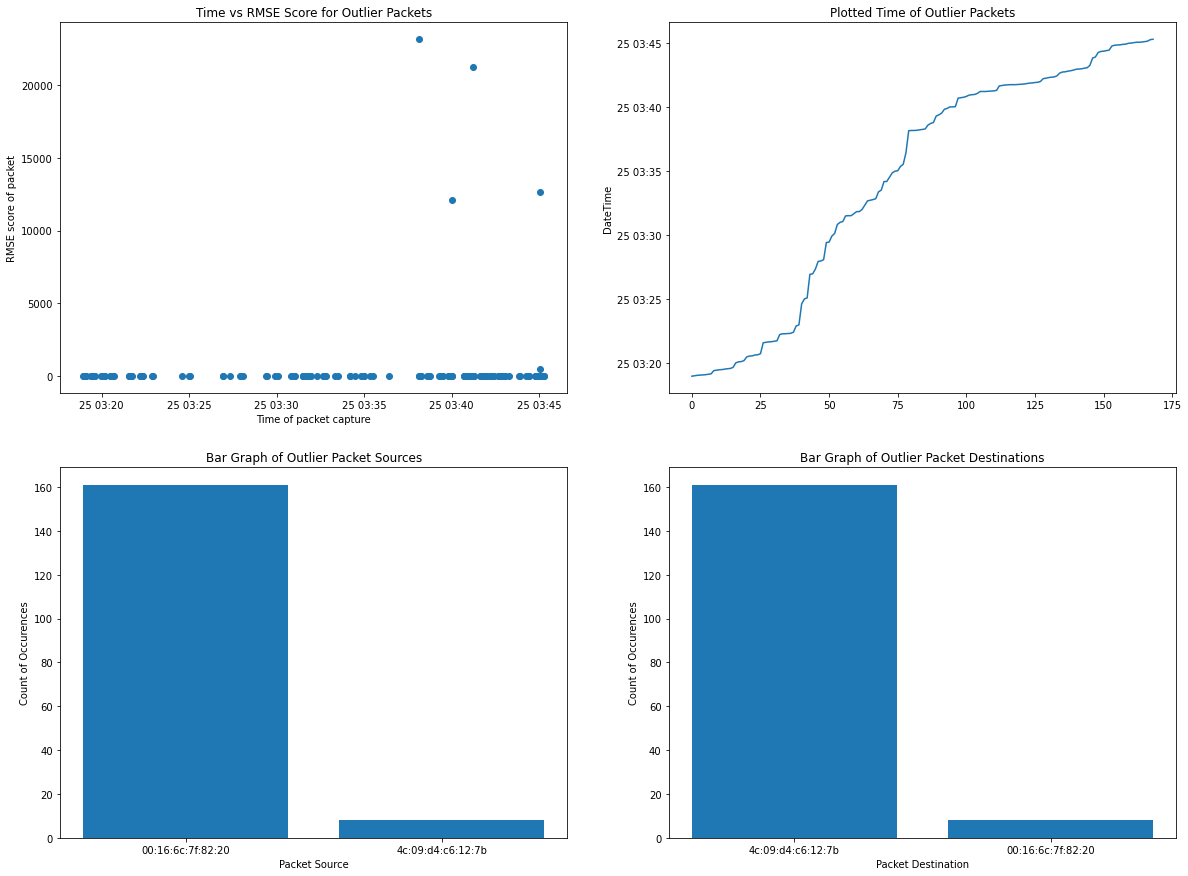

In [121]:
#Plotting the time occurances of some potential anomalies
#Here we can see that a few stand out as definite security threats, and they seem to be grouped closer in time
import matplotlib

f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, sharey=False, figsize=(20,15))

dates = matplotlib.dates.date2num(time)
ax1.plot_date(dates, rmse)
ax1.set_title('Time vs RMSE Score for Outlier Packets')
ax1.set_xlabel('Time of packet capture')
ax1.set_ylabel('RMSE score of packet')

ax2.plot(range(len(time)),time)
ax2.set_title('Plotted Time of Outlier Packets')
ax2.set_ylabel('DateTime')

from collections import Counter

k_src = Counter(source).keys() # equals to list(set(source))
v_src = Counter(source).values() # counts the elements' frequency

ax3.bar(k_src,v_src)
ax3.set_title('Bar Graph of Outlier Packet Sources')
ax3.set_xlabel('Packet Source')
ax3.set_ylabel('Count of Occurences')


k_dst = Counter(dest).keys() 
v_dst = Counter(dest).values() 

ax4.bar(k_dst,v_dst)
ax4.set_title('Bar Graph of Outlier Packet Destinations')
ax4.set_xlabel('Packet Destination')
ax4.set_ylabel('Count of Occurences')